# *Import Libraries*

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, auc, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# *Import Dataset*

In [2]:
BASE_URL = " https://proai-datasets.s3.eu-west-3.amazonaws.com/"
df = pd.read_csv(BASE_URL + "insurance_cross_sell.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# *Check info and missing values*

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [4]:
df.isna().sum() #no missing values

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


# *Exploration Data Analysis*

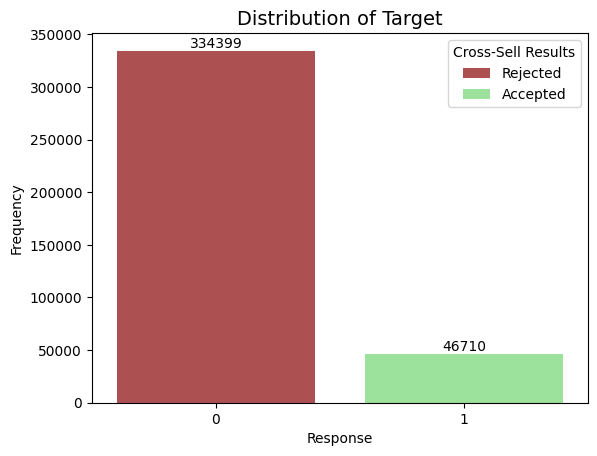

In [5]:
#Distribution target

ax = sns.countplot(data=df, x="Response", palette=["#bc4143", "lightgreen"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Distribution of Target", fontsize=14)
plt.xlabel("Response")
plt.ylabel("Frequency")
plt.legend(labels=["Rejected", "Accepted"], title="Cross-Sell Results")
plt.show()

The percentages of customers for each class are:

* Response 1 (accepted): ≈ **12.26%**
* Response 0 (rejected): ≈ **87.74%**

This confirms that the dataset is imbalanced, with a **large majority of customers rejecting the offer**.

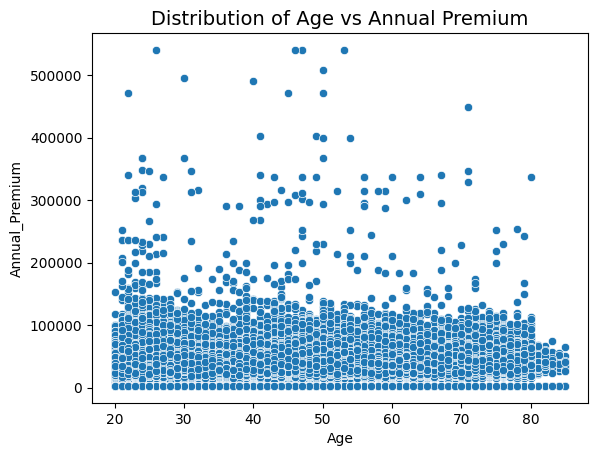

In [6]:
sns.scatterplot(x=df["Age"], y=df["Annual_Premium"])
sns.set_style("whitegrid")
plt.title("Distribution of Age vs Annual Premium", fontsize=14)
plt.show()

It can be seen from the graph that the annual insurance premium amount is stable for all classes up to an amount between 0 and about 160000.
One notices with much greater frequency peaks at a young age, up to about age 55

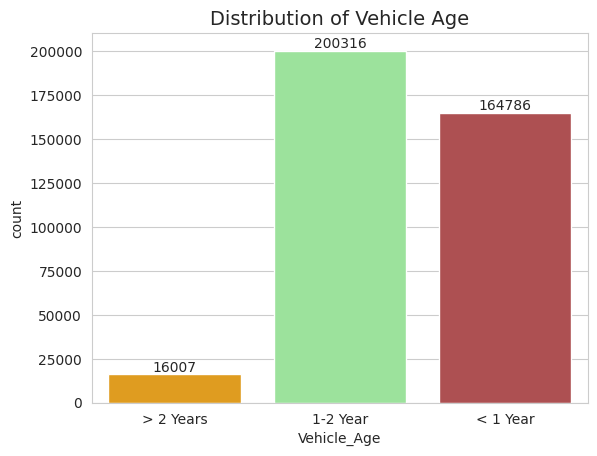

In [14]:
ax = sns.countplot(data=df, x="Vehicle_Age", palette=["orange","lightgreen","#bc4143"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Distribution of Vehicle Age", fontsize=14)
plt.show()

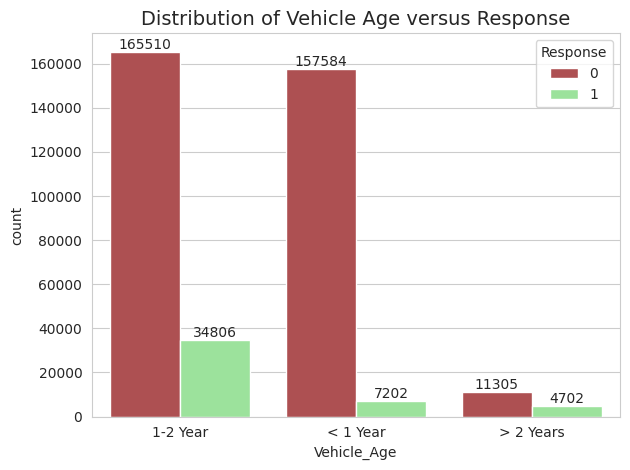

In [9]:
vr = df.groupby(["Vehicle_Age", "Response"]).size().reset_index(name="count")

ax = sns.barplot(data=vr, x="Vehicle_Age", y="count", hue="Response", palette=["#bc4143", "lightgreen"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Distribution of Vehicle Age versus Response", fontsize=14)
plt.tight_layout()
plt.show()

1. *First graph* : A large chunk of customers' vehicle age is between **1-2
years** , followed by vehicles with **less than one year** of registration

2. *Second graph* : The age of the customers' vehicle and the target response variable were related.

  * 1-2 Year : Response 0 (rejected): ≈ 82.62% ;  Response 1 (accepted): ≈ 17.38%
  * < 1 Year : Response 0 (rejected): ≈ 95.6%  ;  Response 1 (accepted): ≈ 4.4%
  * 2+ Years: Response 0 (rejected): ≈ 70.7% ; Response 1 (accepted): ≈ 29.3%


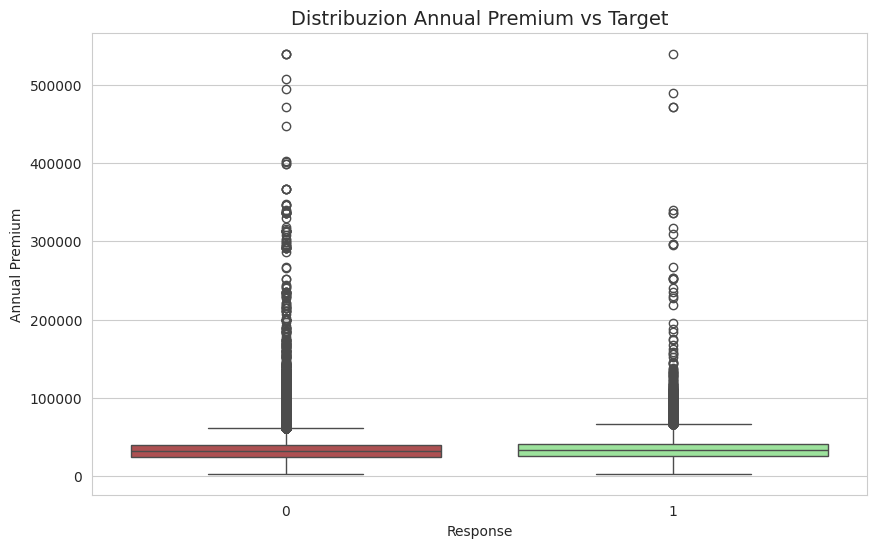

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Response", y="Annual_Premium", data=df, palette=["#bc4143", "lightgreen"]);
plt.title("Distribuzion Annual Premium vs Target", fontsize=14)
plt.xlabel("Response")
plt.ylabel("Annual Premium")
plt.show()

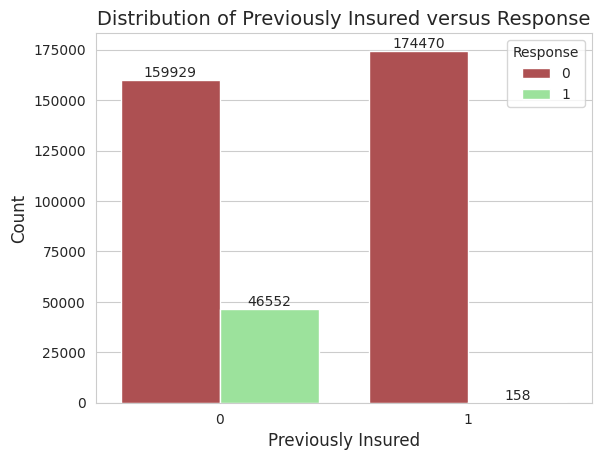

In [11]:
pir = df.groupby(["Previously_Insured", "Response"]).size().reset_index(name="count")

ax = sns.barplot(data=pir, x="Previously_Insured", y="count", hue="Response", palette=["#bc4143", "lightgreen"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Distribution of Previously Insured versus Response", fontsize=14)
plt.xlabel("Previously Insured", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

Distribution of Responses by Previously Insured:

**Uninsured customers** (Previously Insured = 0):

* Rejection: 159.929 clients (≈ 77.5% of uninsured clients)
* Acceptance: 46,552 clients (≈ 22.5% of uninsured clients)


---
**Customers already insured** (Previously Insured = 1):

* Rejection: 174.470 clients (≈ 99.9% of previously insured clients)
* Acceptance: 158 clients (≈ 0.1% of previously insured clients)

It appears that cross-sell (i.e., offering a new insurance policy to a customer) is more likely to be successful with customers who are not already insured.

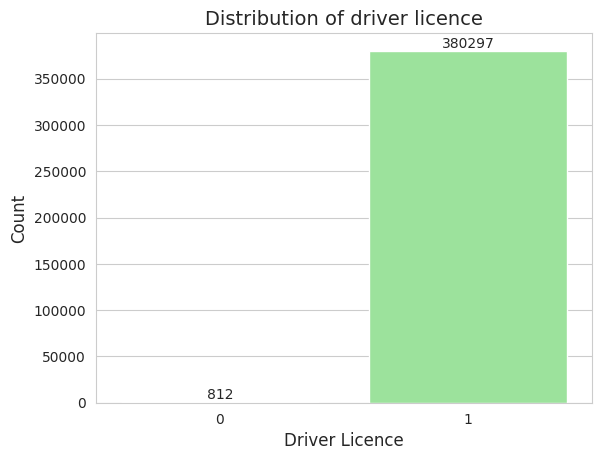

In [12]:
ax = sns.countplot(df,x=df['Driving_License'], palette=["#bc4143", "lightgreen"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Distribution of driver licence", fontsize=14)
plt.xlabel("Driver Licence", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

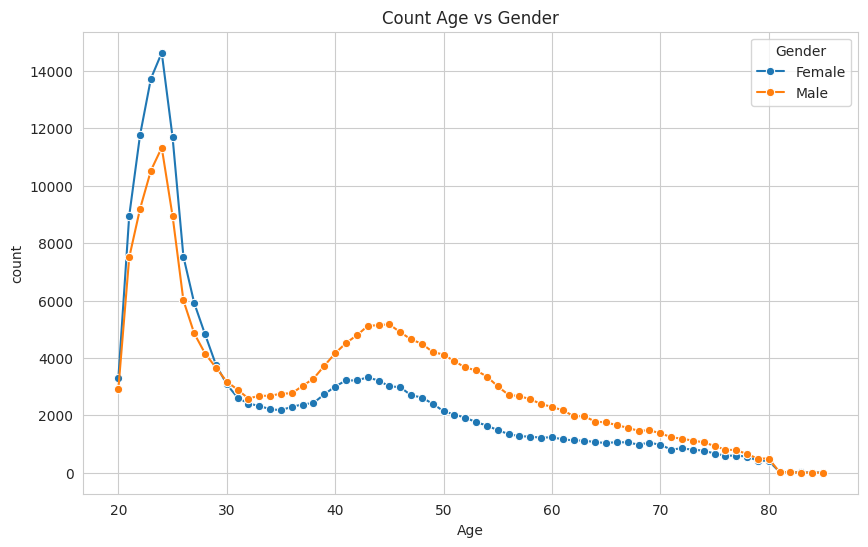

In [13]:
age_gender = df.groupby(['Gender','Age']).size().reset_index(name='count')

plt.figure(figsize=(10,6))
sns.lineplot(data=age_gender, x='Age', y='count', hue='Gender', marker='o')
plt.title('Count Age vs Gender')
plt.show()


# *Data Preprocessing*

In [15]:
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"]) #0:Female, 1:Male
df["Vehicle_Age"] = df["Vehicle_Age"].map({"< 1 Year":0, "1-2 Year":1, "> 2 Years":2})
df["Vehicle_Damage"] = le.fit_transform(df["Vehicle_Damage"])

df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


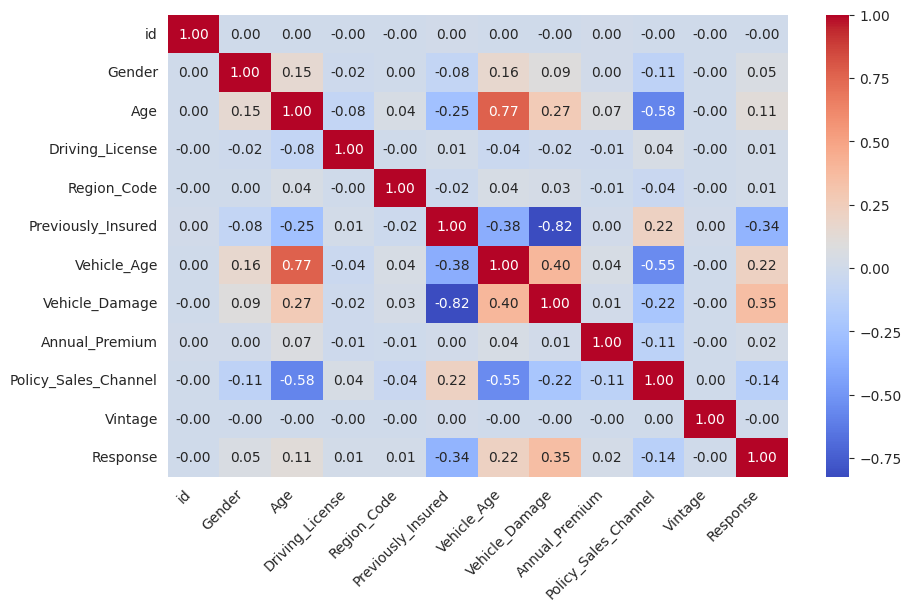

In [16]:
#Correlation Matrix
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt= ".2f", cmap="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.show()

* The *Response* variable is **positively correlated** with *Vehicle Age* and *Vehicle Damage*
* The *Response* variable has a **strong negative correlation** with *Previously Insured*



In [17]:
#Set Variables
X = df.drop(["id","Response"],axis = 1)
y = df["Response"]

X.shape, y.shape


((381109, 10), (381109,))

In [18]:
#Split train e test set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.3, random_state = 1109, stratify = y)

#StandarScaler
ss=StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train.mean(), X_train.std()

(np.float64(-5.878751935592757e-17), np.float64(0.9999999999999997))

# *Class Weight: "Balanced"*

In [19]:
#fit Logisticregression
lr =LogisticRegression(class_weight="balanced", random_state=1109)
lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

#classification reports
print(f"Train Report")
print(classification_report(y_train,y_pred_train))
print(f"***********************************************************")
print(f"Test Report")
print(classification_report(y_test,y_pred_test))
print(f"***********************************************************")
print("Train ROC-AUC:", (roc_auc_score(y_train, y_proba_train[:, 1])))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test[:, 1]))

Train Report
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234079
           1       0.25      0.98      0.40     32697

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

***********************************************************
Test Report
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100320
           1       0.25      0.98      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

***********************************************************
Train ROC-AUC: 0.8318995742166843
Test ROC-AUC: 0.8324794017454289


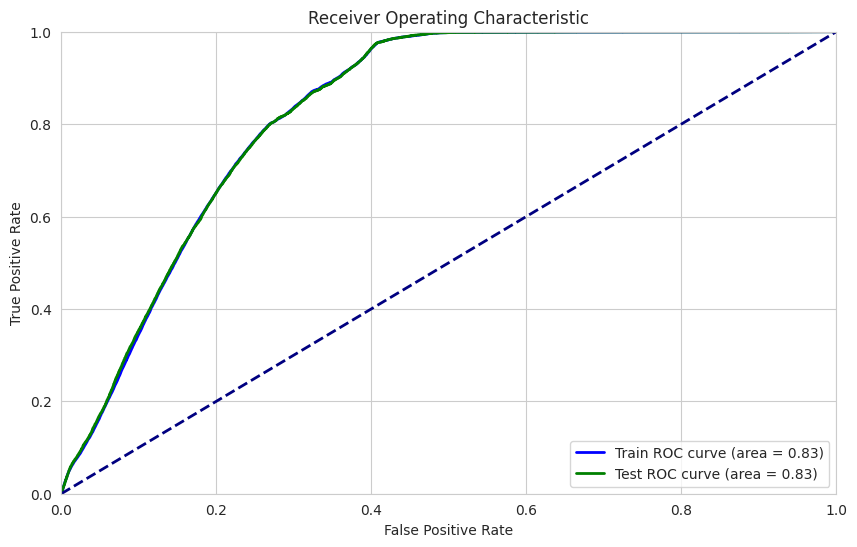

In [20]:
# Calculate FPR (False Positive Rate) and TPR (True Positive Rate) for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate FPR (False Positive Rate)  and TPR (True Positive Rate) for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure(figsize=(10,6))
plt.plot(fpr_train, tpr_train, color="blue", lw=2, label="Train ROC curve (area = %0.2f)" % roc_auc_train)
plt.plot(fpr_test, tpr_test, color="green", lw=2, label="Test ROC curve (area = %0.2f)" % roc_auc_test)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # Diagonal line ROC = 0.5
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# *Smote Model*

In [21]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


model = LogisticRegression(random_state=1109)
model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test)
y_pred_train_resampled = model.predict(X_train_resampled)

print(f"Train Report")
print(classification_report(y_train_resampled,y_pred_train_resampled))
print(f"***********************************************************")
print(f"Test Report")
print(classification_report(y_test,y_pred))

Train Report
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234079
           1       0.71      0.98      0.82    234079

    accuracy                           0.78    468158
   macro avg       0.83      0.78      0.78    468158
weighted avg       0.83      0.78      0.78    468158

***********************************************************
Test Report
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100320
           1       0.25      0.97      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



# *RandomOverSampler model*

In [23]:
ros = RandomOverSampler(random_state=1109)
X_train_ros, y_train_ros = ros.fit_resample(X_train,y_train)

model = LogisticRegression(random_state=1109)
model.fit(X_train_ros, y_train_ros)

y_pred = model.predict(X_test)
y_pred_train_ros = model.predict(X_train_ros)

print(f"Train Report")
print(classification_report(y_train_ros,y_pred_train_ros))
print(f"***********************************************************")
print(f"Test Report")
print(classification_report(y_test,y_pred))

Train Report
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234079
           1       0.71      0.98      0.82    234079

    accuracy                           0.78    468158
   macro avg       0.83      0.78      0.78    468158
weighted avg       0.83      0.78      0.78    468158

***********************************************************
Test Report
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100320
           1       0.25      0.98      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



Being an unbalanced dataset, three different tests were performed:
 1. Class_weight method
 2. SMOTE method
 3. RandomOverSampling method

In all three cases, the exact same results were observed on the test set, although some improvement was recorded in the training sets. Even changing the threshold to 0.25 did not affect the results.

As far as Logistic Regression is concerned, there may not be much room for significant improvement in terms of metrics. However, the high-recall model could be useful for identifying potential customers to target for cross-selling, particularly by focusing on those who are more likely to accept.

The model maintains an **accuracy** of 64%, but this metric is not meaningful due to the imbalanced nature of the dataset.
**Recall** of 98% can be good in situations where it is crucial to identify all positive instances (e.g. potential customers for a marketing campaign)
The **ROC-AUC** value is 0.83, meaning that the model is able to correctly distinguish between positive and negative classes, considering the decision threshold.

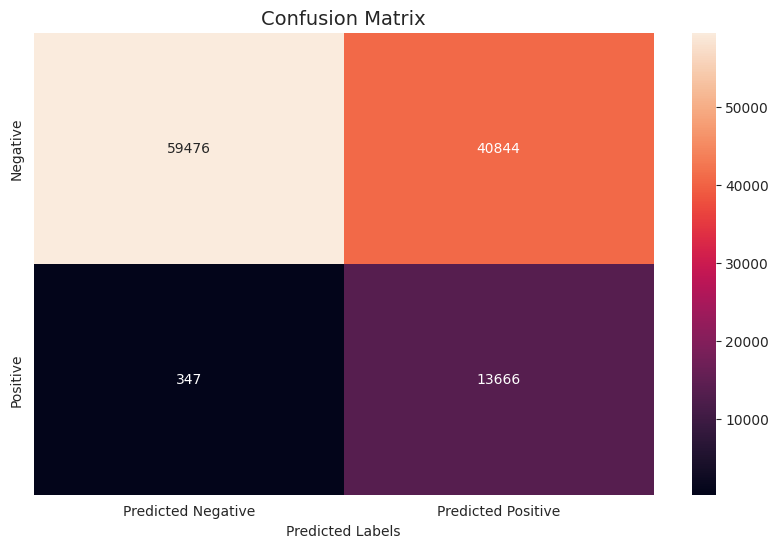

In [24]:
#Matrix confusion
cm = confusion_matrix(y_test,y_pred_test)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix", fontsize = 14)
plt.show()

Values in the matrix:
* True Negatives (**TN**) (top left, value: 59.476):
The model *correctly* classified 59.496 negative examples as negatives.
* False Positives (**FP**) (top right, value: 40.844):
The model *incorrectly* classified 40,844 negative examples as positive.
* False Negatives (**FN**) (bottom left, value: 347):
The model *misclassified* 332 positive examples as negative.
* True Positives (**TP**) (bottom right, value: 13.806):
The model *correctly* classified 13.666 positive examples as positive.

---
# *Final Conclusions:*
Regarding **Logistic Regression**, there may be limited potential for improvement in terms of traditional metrics. However, a model with high recall can be valuable for identifying potential customers for cross-selling, particularly if we focus on those more likely to accept the offer.

The graphical analysis reveals that 22.5% of uninsured customers are more likely to accept a cross-sell proposal.

Customers with cars that are over 2 years old have a cross-sell acceptance rate of 29.3%.

Customers with cars that are 1-2 years old have a cross-sell acceptance rate of 17.38%.

**Metrics: Recall**

If you want to reach more potentially interested customers, even risk a few mistakes.

➤ It is good if losing an interested customer is very costly.

➤ You use the model in order not to lose any opportunities.

**Targeting this segment could significantly boost sales.**
